<a href="https://colab.research.google.com/github/charlottenoort/GEOG_606_Project/blob/main/GEOG_606_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GEOG 606 Project**

In [ ]:
# Import relevant notebooks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [ ]:
# Grant notebook access to Google Earth Engine
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-charlottenoort')

# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Steps:**
1. Import PM2.5 dataset
2. Isolate desired stations and condense hourly PM2.5 values into daily means for each location
3. Import Earth Engine terraclimate dataset
4. Isolate daily precipitation values in the Terraclimate dataset for each location in PM2.5 dataset
5. Combine PM2.5 and precipitation data for each station
6. Plot monthly precipitation values against time in an X-Y scatter plot
7. Create a univariate plot of PM2.5 daily means
8. Create a time-series plot, with two y-axes showing precipitation and PM2.5 means on a shared temporal x-axis
9. Create a data summary table

##1. Import PM2.5 dataset

In [ ]:
# Import csv describing PM2.5 data.
from google.colab import files


PM25_2023 = uploaded = files.upload()

Saving PM2.5 values.csv to PM2.5 values.csv


In [ ]:
# Get the filename from the uploaded dictionary
PM25_2023 = list(uploaded.keys())[0]

# Read the CSV file into a pandas dataframe
df = pd.read_csv(PM25_2023)
df.head()

,DATE_PST,DATE,TIME,STATION_NAME,STATION_NAME_FULL,EMS_ID,NAPS_ID,RAW_VALUE,ROUNDED_VALUE,UNIT,INSTRUMENT,PARAMETER,OWNER,REGION
0,2023-01-01 1:00,2023-01-01,1:00,Abbotsford A Columbia Street,ABBOTSFORD A COLUMBIA STREET,E289309,10,4.384691,4.4,ug/m3,PM25 SHARP5030,PM25,MVRD,02 - Lower Mainland
1,2023-01-01 2:00,2023-01-01,2:00,Abbotsford A Columbia Street,ABBOTSFORD A COLUMBIA STREET,E289309,10,4.785833,4.8,ug/m3,PM25 SHARP5030,PM25,MVRD,02 - Lower Mainland
2,2023-01-01 3:00,2023-01-01,3:00,Abbotsford A Columbia Street,ABBOTSFORD A COLUMBIA STREET,E289309,10,6.001417,6.0,ug/m3,PM25 SHARP5030,PM25,MVRD,02 - Lower Mainland
3,2023-01-01 4:00,2023-01-01,4:00,Abbotsford A Columbia Street,ABBOTSFORD A COLUMBIA STREET,E289309,10,3.511139,3.5,ug/m3,PM25 SHARP5030,PM25,MVRD,02 - Lower Mainland
4,2023-01-01 5:00,2023-01-01,5:00,Abbotsford A Columbia Street,ABBOTSFORD A COLUMBIA STREET,E289309,10,2.357556,2.4,ug/m3,PM25 SHARP5030,PM25,MVRD,02 - Lower Mainland


## 2. Isolate desired stations and condense hourly PM2.5 values into daily means for each location

In [ ]:
# Filter the original df so that only rows with STATION_NAME "Abbotsford Central", " Chilliwack Airport", "New Westminster Sapperton Park", "North Vancouver Mahon Park", and "Vancouver International Airport #2" are kept
df_lowermainland = df[df['STATION_NAME'].isin(['Abbotsford Central', 'Chilliwack Airport', 'New Westminster Sapperton Park', 'North Vancouver Mahon Park', 'Vancouver International Airport #2'])]

# Reorganize the dataframe so that the unique values in STATION_NAME become their own columns whose data is the value in the column currently called RAW_VALUE
df_pivot = df_lowermainland.pivot_table(index='DATE', columns='STATION_NAME', values='RAW_VALUE', aggfunc='mean')
df_pivot.head()

STATION_NAME,Abbotsford Central,Chilliwack Airport,New Westminster Sapperton Park,North Vancouver Mahon Park,Vancouver International Airport #2
DATE,,,,,
2023-01-01,7.355490,3.784490,5.662083,2.618416,7.845452
2023-01-02,2.008330,1.507916,3.551667,4.824387,6.148929
2023-01-03,3.418273,1.347971,4.153333,1.713336,3.379138
2023-01-04,2.240341,1.147005,3.506316,3.059178,3.965842
2023-01-05,3.215005,1.355457,3.128195,2.509507,2.721243


In [ ]:
# Resample the data to get monthly means
# Ensure the index is of datetime type
df_pivot.index = pd.to_datetime(df_pivot.index)

monthly_means = df_pivot.resample('M').mean()

# Display the result
monthly_means.head()

<ipython-input-6-83176225a426>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_means = df_pivot.resample('M').mean()


STATION_NAME,Abbotsford Central,Chilliwack Airport,New Westminster Sapperton Park,North Vancouver Mahon Park,Vancouver International Airport #2
DATE,,,,,
2023-01-31,4.166629,3.508414,4.443686,2.912561,4.351606
2023-02-28,4.550128,3.656836,4.997558,2.973333,4.550499
2023-03-31,4.720103,4.313498,4.955958,3.996328,5.461643
2023-04-30,4.888578,3.682246,4.416392,3.578347,3.438401
2023-05-31,6.310070,6.125920,6.945669,6.205195,5.597767


In [ ]:
# Change the values in the DATE column to only show the year and month
monthly_means.index = monthly_means.index.strftime('%Y-%m')
monthly_means.head()

STATION_NAME,Abbotsford Central,Chilliwack Airport,New Westminster Sapperton Park,North Vancouver Mahon Park,Vancouver International Airport #2
DATE,,,,,
2023-01,4.166629,3.508414,4.443686,2.912561,4.351606
2023-02,4.550128,3.656836,4.997558,2.973333,4.550499
2023-03,4.720103,4.313498,4.955958,3.996328,5.461643
2023-04,4.888578,3.682246,4.416392,3.578347,3.438401
2023-05,6.310070,6.125920,6.945669,6.205195,5.597767


In [ ]:
monthly_means.describe()

STATION_NAME,Abbotsford Central,Chilliwack Airport,New Westminster Sapperton Park,North Vancouver Mahon Park,Vancouver International Airport #2
count,12.000000,12.000000,12.000000,12.000000,12.000000
mean,5.597922,5.981849,5.882515,4.565744,5.108959
std,1.676085,3.338770,1.451498,1.719253,1.116273
min,4.166629,3.508414,4.416392,2.912561,3.438401
25%,4.677609,3.984985,4.973958,3.427094,4.338296
50%,5.119178,5.523117,5.649482,4.162736,5.006071
75%,5.800569,6.183904,6.482638,4.999319,5.811376
max,10.508608,15.860273,9.668472,9.019236,7.163514


(0.0, 30.0)

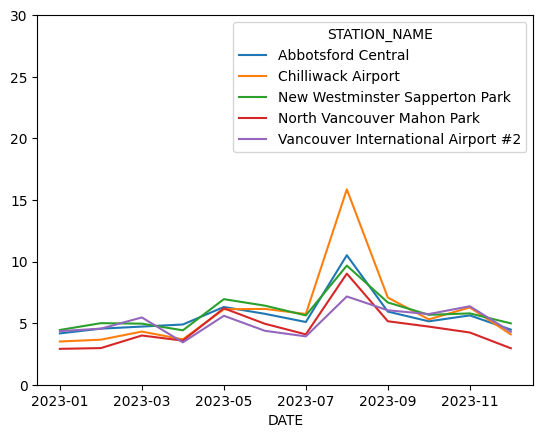

In [ ]:
# Display data
monthly_means.plot()
plt.ylim(0,30)

##3. Import Earth Engine terraclimate dataset

In [ ]:
ET = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE')
ET.first().getInfo()

{'type': 'Image',
 'bands': [{'id': 'aet',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': -32768,
    'max': 32767},
   'dimensions': [8640, 4320],
   'crs': 'GEOGCS["unknown", \n  DATUM["unknown", \n    SPHEROID["Spheroid", 6378137.0, 298.257223563]], \n  PRIMEM["Greenwich", 0.0], \n  UNIT["degree", 0.017453292519943295], \n  AXIS["Longitude", EAST], \n  AXIS["Latitude", NORTH]]',
   'crs_transform': [0.041666666666666664,
    0,
    -180,
    0,
    -0.041666666666666664,
    90]},
  {'id': 'def',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': -32768,
    'max': 32767},
   'dimensions': [8640, 4320],
   'crs': 'GEOGCS["unknown", \n  DATUM["unknown", \n    SPHEROID["Spheroid", 6378137.0, 298.257223563]], \n  PRIMEM["Greenwich", 0.0], \n  UNIT["degree", 0.017453292519943295], \n  AXIS["Longitude", EAST], \n  AXIS["Latitude", NORTH]]',
   'crs_transform': [0.041666666666666664,
    0,
    -180,
    0,
    -0.041666666666666664,
    90]

In [ ]:
# Import Idaho Epscor Terraclimate data.
terraclim = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE')

In [ ]:
# Reduce Terraclimate dataset to only include 2023 dates
terraclim = terraclim.filterDate('2023-01-01', '2023-12-31')

# Display terraclim data band names
terraclim.first().bandNames().getInfo()

['aet',
 'def',
 'pdsi',
 'pet',
 'pr',
 'ro',
 'soil',
 'srad',
 'swe',
 'tmmn',
 'tmmx',
 'vap',
 'vpd',
 'vs']

##4. Isolate daily precipitation values in the Terraclimate dataset for each location in PM2.5 dataset

**Latitude and longitude of each PM2.5 station of interest:**

Abbotsford Central: -122.3020, 49.0427

Chilliwack Airport: -121.9436, 49.1550

New Westminster Sapperton Park: -122.8945, 49.22701

North Vancouver Mahon Park: -123.0835, 49.3240

Vancouver International Airport #2: -123.1751, 49.1934

In [ ]:
# Define a function to extract values at a point
def extract_pr_at_point(image, point, location_name):
    pr_value = image.select('pr').reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=point,
        scale=30,
    ).get('pr')

    # Create a Feature with the extracted value and location name
    return ee.Feature(None, {'pr': pr_value, 'location': location_name, 'date': image.date().format('YYYY-MM-dd')})

# Create point geometries for each location
point_Abbotsford_Central = ee.Geometry.Point(-122.3020, 49.0427)
point_Chilliwack_Airport = ee.Geometry.Point(-121.9436, 49.1550)
point_Sapperton_Park = ee.Geometry.Point(-122.8945, 49.22701)
point_Mahon_Park = ee.Geometry.Point(-123.0835, 49.3240)
point_YVR = ee.Geometry.Point(-123.1751, 49.1934)

# Map the extraction function over the image collection
pr_Abbotsford_Central = terraclim.map(lambda image: extract_pr_at_point(image, point_Abbotsford_Central, 'Abbotsford_Central'))
pr_Chilliwack_Airport = terraclim.map(lambda image: extract_pr_at_point(image, point_Chilliwack_Airport, 'Chilliwack_Airport'))
pr_Sapperton_Park = terraclim.map(lambda image: extract_pr_at_point(image, point_Sapperton_Park, 'Sapperton_Park'))
pr_Mahon_Park = terraclim.map(lambda image: extract_pr_at_point(image, point_Mahon_Park, 'Mahon_Park'))
pr_YVR = terraclim.map(lambda image: extract_pr_at_point(image, point_YVR,'YVR'))

# Convert to a list and retrieve the values
pr_Abbotsford_Central_values = pr_Abbotsford_Central.getInfo()['features']
pr_Chilliwack_Airport_values = pr_Chilliwack_Airport.getInfo()['features']
pr_Sapperton_Park_values = pr_Sapperton_Park.getInfo()['features']
pr_Mahon_Park_values = pr_Mahon_Park.getInfo()['features']
pr_YVR_values = pr_YVR.getInfo()['features']

# Print the extracted values
print("pr values at Abbotsford Central:", pr_Abbotsford_Central_values)
print("pr values at Chilliwack Airport:", pr_Chilliwack_Airport_values)
print("pr values at Sapperton Park:", pr_Sapperton_Park_values)
print("pr values at Mahon Park:", pr_Mahon_Park_values)
print("pr values at YVR:", pr_YVR_values)

pr values at Abbotsford Central: [{'type': 'Feature', 'geometry': None, 'id': '202301', 'properties': {'date': '2023-01-01', 'location': 'Abbotsford_Central', 'pr': 139}}, {'type': 'Feature', 'geometry': None, 'id': '202302', 'properties': {'date': '2023-02-01', 'location': 'Abbotsford_Central', 'pr': 148}}, {'type': 'Feature', 'geometry': None, 'id': '202303', 'properties': {'date': '2023-03-01', 'location': 'Abbotsford_Central', 'pr': 92}}, {'type': 'Feature', 'geometry': None, 'id': '202304', 'properties': {'date': '2023-04-01', 'location': 'Abbotsford_Central', 'pr': 167}}, {'type': 'Feature', 'geometry': None, 'id': '202305', 'properties': {'date': '2023-05-01', 'location': 'Abbotsford_Central', 'pr': 33}}, {'type': 'Feature', 'geometry': None, 'id': '202306', 'properties': {'date': '2023-06-01', 'location': 'Abbotsford_Central', 'pr': 35}}, {'type': 'Feature', 'geometry': None, 'id': '202307', 'properties': {'date': '2023-07-01', 'location': 'Abbotsford_Central', 'pr': 25}}, {'ty

In [ ]:
# Create a list of all pr_values
all_pr_values = [pr_Abbotsford_Central_values, pr_Chilliwack_Airport_values,
                 pr_Sapperton_Park_values, pr_Mahon_Park_values, pr_YVR_values]

# Create a list to store dataframes for each location
pr_dfs = []

# Iterate through the list of pr_values and create DataFrames
for pr_values, location_name in zip(all_pr_values, ['Abbotsford_Central', 'Chilliwack_Airport', 'Sapperton_Park', 'Mahon_Park', 'YVR']):
  data = [{'date': feature['properties']['date'], 'pr': feature['properties']['pr'], 'location': feature['properties']['location']}
          for feature in pr_values]
  df = pd.DataFrame(data)
  pr_dfs.append(df)

# Concatenate all the DataFrames into one
pr_df = pd.concat(pr_dfs)

# Pivot the DataFrame to have locations as columns
pr_df_pivot = pr_df.pivot_table(index='date', columns='location', values='pr')

# Change the DataFrame to display 'date' as year and month only
pr_df_pivot.index = pd.to_datetime(pr_df_pivot.index)
pr_df_pivot.index = pr_df_pivot.index.strftime('%Y-%m')

# Display the DataFrame
pr_df_pivot.head()

location,Abbotsford_Central,Chilliwack_Airport,Mahon_Park,Sapperton_Park,YVR
date,,,,,
2023-01,139.0,153.0,245.0,235.0,149.0
2023-02,148.0,158.0,155.0,157.0,104.0
2023-03,92.0,94.0,88.0,86.0,56.0
2023-04,167.0,160.0,205.0,202.0,131.0
2023-05,33.0,38.0,34.0,33.0,24.0


## 5. Combine PM2.5 and precipitation data for each station

In [ ]:
# Combine pr_df_pivot with monthly_means corresponding to the shared dates in both datasets
combined_df = pd.merge(monthly_means, pr_df_pivot, left_on='DATE', right_index=True)

# Display the combined DataFrame
combined_df.head()

,Abbotsford Central,Chilliwack Airport,New Westminster Sapperton Park,North Vancouver Mahon Park,Vancouver International Airport #2,Abbotsford_Central,Chilliwack_Airport,Mahon_Park,Sapperton_Park,YVR
DATE,,,,,,,,,,
2023-01,4.166629,3.508414,4.443686,2.912561,4.351606,139.0,153.0,245.0,235.0,149.0
2023-02,4.550128,3.656836,4.997558,2.973333,4.550499,148.0,158.0,155.0,157.0,104.0
2023-03,4.720103,4.313498,4.955958,3.996328,5.461643,92.0,94.0,88.0,86.0,56.0
2023-04,4.888578,3.682246,4.416392,3.578347,3.438401,167.0,160.0,205.0,202.0,131.0
2023-05,6.310070,6.125920,6.945669,6.205195,5.597767,33.0,38.0,34.0,33.0,24.0


In [ ]:
# Rename columns to correspond with data names
combined_df.rename(columns={'Abbotsford Central': 'Abbotsford Central PM2.5'}, inplace=True)
combined_df.rename(columns={'Abbotsford_Central': 'Abbotsford Central Precipitation'}, inplace=True)
combined_df.rename(columns={'Chilliwack Airport': 'Chilliwack Airport PM2.5'}, inplace=True)
combined_df.rename(columns={'Chilliwack_Airport': 'Chilliwack Airport Precipitation'}, inplace=True)
combined_df.rename(columns={'New Westminster Sapperton Park': 'Sapperton Park PM2.5'}, inplace=True)
combined_df.rename(columns={'Sapperton_Park': 'Sapperton Park Precipitation'}, inplace=True)
combined_df.rename(columns={'North Vancouver Mahon Park': 'Mahon Park PM2.5'}, inplace=True)
combined_df.rename(columns={'Mahon_Park': 'Mahon Park Precipitation'}, inplace=True)
combined_df.rename(columns={'Vancouver International Airport #2': 'YVR PM2.5'}, inplace=True)
combined_df.rename(columns={'YVR': 'YVR Precipitation'}, inplace=True)
combined_df.head()

,Abbotsford Central PM2.5,Chilliwack Airport PM2.5,Sapperton Park PM2.5,Mahon Park PM2.5,YVR PM2.5,Abbotsford Central Precipitation,Chilliwack Airport Precipitation,Mahon Park Precipitation,Sapperton Park Precipitation,YVR Precipitation
DATE,,,,,,,,,,
2023-01,4.166629,3.508414,4.443686,2.912561,4.351606,139.0,153.0,245.0,235.0,149.0
2023-02,4.550128,3.656836,4.997558,2.973333,4.550499,148.0,158.0,155.0,157.0,104.0
2023-03,4.720103,4.313498,4.955958,3.996328,5.461643,92.0,94.0,88.0,86.0,56.0
2023-04,4.888578,3.682246,4.416392,3.578347,3.438401,167.0,160.0,205.0,202.0,131.0
2023-05,6.310070,6.125920,6.945669,6.205195,5.597767,33.0,38.0,34.0,33.0,24.0


In [ ]:
# What is the total mean of all the values in each column ending in "Precipitation"? (aka, mean annual precipitation of the lower mainland)
Mean_annual_lm_precip = combined_df.filter(like='Precipitation').mean().mean()
print(Mean_annual_lm_precip)

109.06666666666668


##6. Plot monthly precipitation values against time in an X-Y scatter plot, with colour and/or symbol denoting categories

In [ ]:
# Add column to combined df DATE
combined_df['DATE'] = combined_df.index
combined_df.head()

,Abbotsford Central PM2.5,Chilliwack Airport PM2.5,Sapperton Park PM2.5,Mahon Park PM2.5,YVR PM2.5,Abbotsford Central Precipitation,Chilliwack Airport Precipitation,Mahon Park Precipitation,Sapperton Park Precipitation,YVR Precipitation,DATE
DATE,,,,,,,,,,,
2023-01,4.166629,3.508414,4.443686,2.912561,4.351606,139.0,153.0,245.0,235.0,149.0,2023-01
2023-02,4.550128,3.656836,4.997558,2.973333,4.550499,148.0,158.0,155.0,157.0,104.0,2023-02
2023-03,4.720103,4.313498,4.955958,3.996328,5.461643,92.0,94.0,88.0,86.0,56.0,2023-03
2023-04,4.888578,3.682246,4.416392,3.578347,3.438401,167.0,160.0,205.0,202.0,131.0,2023-04
2023-05,6.310070,6.125920,6.945669,6.205195,5.597767,33.0,38.0,34.0,33.0,24.0,2023-05


In [ ]:
# Convert the DATE column into a datetime
combined_df['DATE'] = pd.to_datetime(combined_df['DATE'])

In [ ]:
# Reformat the DATE column to show values in month names only
combined_df['DATE'] = combined_df['DATE'].dt.strftime('%b')
combined_df.head()

,Abbotsford Central PM2.5,Chilliwack Airport PM2.5,Sapperton Park PM2.5,Mahon Park PM2.5,YVR PM2.5,Abbotsford Central Precipitation,Chilliwack Airport Precipitation,Mahon Park Precipitation,Sapperton Park Precipitation,YVR Precipitation,DATE
DATE,,,,,,,,,,,
2023-01,4.166629,3.508414,4.443686,2.912561,4.351606,139.0,153.0,245.0,235.0,149.0,Jan
2023-02,4.550128,3.656836,4.997558,2.973333,4.550499,148.0,158.0,155.0,157.0,104.0,Feb
2023-03,4.720103,4.313498,4.955958,3.996328,5.461643,92.0,94.0,88.0,86.0,56.0,Mar
2023-04,4.888578,3.682246,4.416392,3.578347,3.438401,167.0,160.0,205.0,202.0,131.0,Apr
2023-05,6.310070,6.125920,6.945669,6.205195,5.597767,33.0,38.0,34.0,33.0,24.0,May


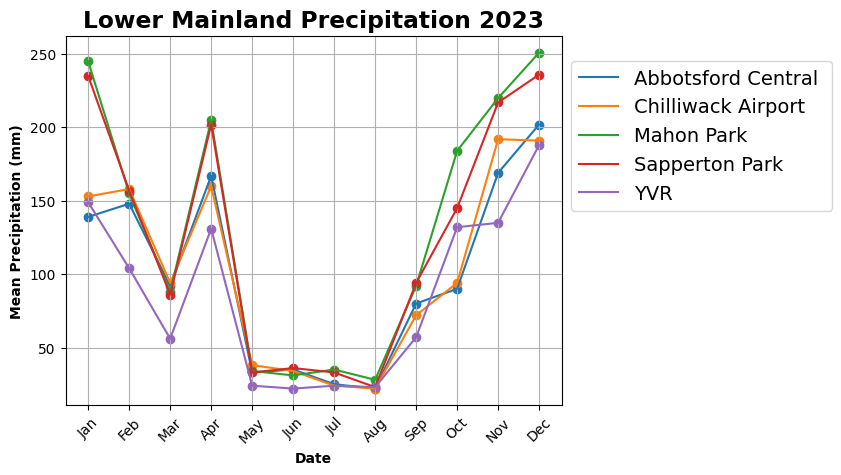

In [ ]:
# Make each column name ending in "Precipitation" a separate data line including all their unique values on an X-Y scatter plot against DATE values
for column in combined_df.columns:
  if column.endswith('Precipitation'):
    plt.plot(combined_df['DATE'], combined_df[column], label=column)

# Add unlabelled scatter points for each data value in each dataline
for column in combined_df.columns:
  if column.endswith('Precipitation'):
    plt.scatter(combined_df['DATE'], combined_df[column], label=None)

# Rotate the x-axis ticks for clarity
plt.xticks(rotation=45)

# Add bolded labels
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Mean Precipitation (mm)', fontweight='bold')

# Increase the font size
plt.rcParams.update({'font.size': 14})

# Create a legend but remove the word 'Precipitation' from each data line name
handles, labels = plt.gca().get_legend_handles_labels()
labels = [label.replace('Precipitation', '') for label in labels]
labels.extend(['Total Mean Annual', ''])

# Plot the legend beside the figure
plt.legend(handles, labels, loc='lower left', bbox_to_anchor=(1, 0.5))

# Add gridlines
plt.grid(True)

# Add title
plt.title('Lower Mainland Precipitation 2023', fontweight='bold')

plt.show()

##7. Create univariate plot of PM2.5 daily means


In [ ]:
# Refer back to calculated daily PM2.5 means from step 2
df_pivot.head()

STATION_NAME,Abbotsford Central,Chilliwack Airport,New Westminster Sapperton Park,North Vancouver Mahon Park,Vancouver International Airport #2
DATE,,,,,
2023-01-01,7.355490,3.784490,5.662083,2.618416,7.845452
2023-01-02,2.008330,1.507916,3.551667,4.824387,6.148929
2023-01-03,3.418273,1.347971,4.153333,1.713336,3.379138
2023-01-04,2.240341,1.147005,3.506316,3.059178,3.965842
2023-01-05,3.215005,1.355457,3.128195,2.509507,2.721243


In [ ]:
# Rename df_pivot to daily_pm25
daily_pm25_means = df_pivot

# Combine all the values in each columns in daily_PM25_means into one column of data
pm25_df = daily_pm25_means.stack()

# Display the pm25_df
pm25_df.head()

DATE        STATION_NAME                      
2023-01-01  Abbotsford Central                    7.355490
            Chilliwack Airport                    3.784490
            New Westminster Sapperton Park        5.662083
            North Vancouver Mahon Park            2.618416
            Vancouver International Airport #2    7.845452
dtype: float64

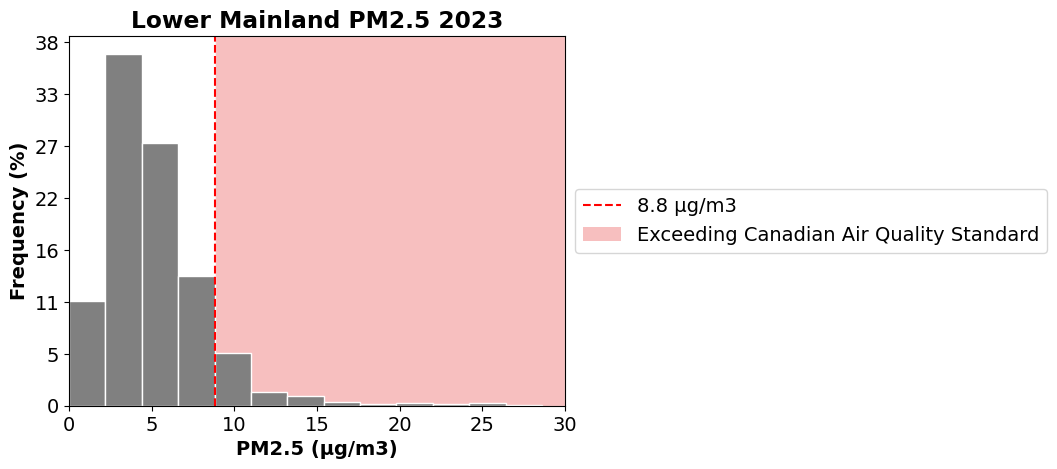

In [ ]:
# Create a histogram of pm25_df with x-axis each bins ending every 8.8
plt.hist(pm25_df, bins=np.arange(0, 30, 2.2), edgecolor='black')

# Display frequency on the y-axis as a percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}'.format(y / len(pm25_df) *100)))

# Decrease the scale of the x-axis
plt.xlim(0, 30)

# Add labels and make them bolded
plt.xlabel('PM2.5 (µg/m3)', fontweight='bold')
plt.ylabel('Frequency (%)', fontweight='bold')

# Increase the font size
plt.rcParams.update({'font.size': 14})

# Add a vertical labelled red dashed line at x = 8.8
plt.axvline(x=8.8, color='red', linestyle='--', label='8.8')

# Change the colour of the data bars to blue
for patch in plt.gca().patches:
    patch.set_facecolor('grey')

# Change the background plot colour to the right of x = 8.8
plt.axvspan(8.8, 30, color='lightcoral', alpha=0.5, zorder=-1)

# Add title
plt.title('Lower Mainland PM2.5 2023', fontweight='bold')

# Put a white outline around each bar
for patch in plt.gca().patches:
    patch.set_edgecolor('white')

handles = [plt.Line2D([0], [0], color='red', linestyle='--'),
          plt.Rectangle((0,0),1,1, fc='lightcoral', alpha=0.5),]
labels = ['8.8 µg/m3', 'Exceeding Canadian Air Quality Standard']

# Plot the legend
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [ ]:
# What is the frequency of PM2.5 values that are over 8.8?
len(pm25_df[pm25_df > 8.8])

186

In [ ]:
# What is the percentage of PM2.5 values that are over 8.8?
len(pm25_df[pm25_df > 8.8]) / len(pm25_df) * 100

10.202962150301701

##8. Create time-series plot, with two y-axes showing precipitation and PM2.5 values on a shared temporal x-axis


In [ ]:
combined_df.head()

,Abbotsford Central PM2.5,Chilliwack Airport PM2.5,Sapperton Park PM2.5,Mahon Park PM2.5,YVR PM2.5,Abbotsford Central Precipitation,Chilliwack Airport Precipitation,Mahon Park Precipitation,Sapperton Park Precipitation,YVR Precipitation,DATE
DATE,,,,,,,,,,,
2023-01,4.166629,3.508414,4.443686,2.912561,4.351606,139.0,153.0,245.0,235.0,149.0,Jan
2023-02,4.550128,3.656836,4.997558,2.973333,4.550499,148.0,158.0,155.0,157.0,104.0,Feb
2023-03,4.720103,4.313498,4.955958,3.996328,5.461643,92.0,94.0,88.0,86.0,56.0,Mar
2023-04,4.888578,3.682246,4.416392,3.578347,3.438401,167.0,160.0,205.0,202.0,131.0,Apr
2023-05,6.310070,6.125920,6.945669,6.205195,5.597767,33.0,38.0,34.0,33.0,24.0,May


In [ ]:
# split combined_df into two separate dataframes: one with only the DATE column and every column ending in 'PM2.5', and another with only the DATE column and every column ending in 'Pecipitation'
df_pm25 = combined_df.filter(like='PM2.5')
df_pr = combined_df.filter(like='Precipitation')

In [ ]:
# Make a copy of the original df_pm25
df_pm25_mean = df_pm25.mean(axis=1)

# Make df_pm25_mean into a new dataframe with two columns, one showing the DATE and the other showing the mean values
df_pm25_final = pd.DataFrame({'DATE': df_pm25.index, 'Mean PM2.5': df_pm25_mean.values.flatten()}) # Flatten the values to make it 1-dimensional

# Convert 'DATE' column to datetime objects
df_pm25_final['DATE'] = pd.to_datetime(df_pm25_final['DATE'])

# Now apply strftime to format the datetime objects
df_pm25_final['DATE'] = df_pm25_final['DATE'].dt.strftime('%b')

df_pm25_final.head()

,DATE,Mean PM2.5
0,Jan,3.876579
1,Feb,4.145671
2,Mar,4.689506
3,Apr,4.000793
4,May,6.236924


In [ ]:
# Make a copy of the original df_pr
df_pr_mean = df_pr.mean(axis=1)

# Make df_pr_mean into a new dataframe with two columns, one showing the DATE and the other showing the mean values
df_pr_final = pd.DataFrame({'DATE': df_pr.index, 'Mean Precipitation': df_pr_mean.values.flatten()}) # Flatten the values to make it 1-dimensional

# Convert 'DATE' column to datetime objects
df_pr_final['DATE'] = pd.to_datetime(df_pr_final['DATE'])

# Now apply strftime to format the datetime objects
df_pr_final['DATE'] = df_pr_final['DATE'].dt.strftime('%b')

df_pr_final.head()

,DATE,Mean Precipitation
0,Jan,184.2
1,Feb,144.4
2,Mar,83.2
3,Apr,173.0
4,May,32.4


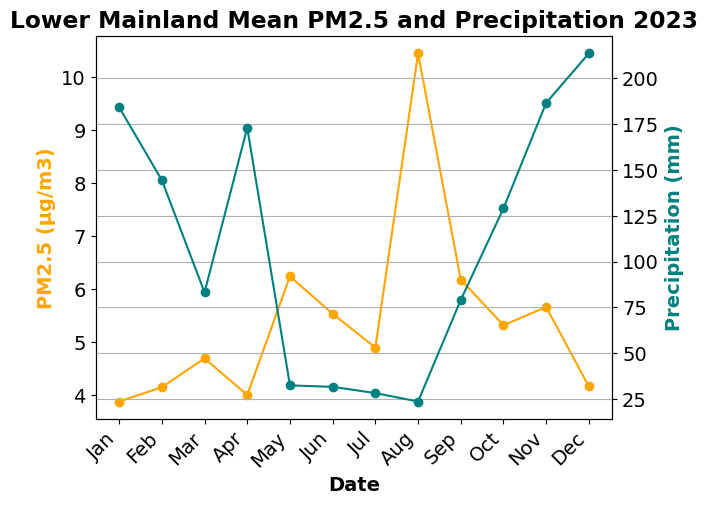

In [ ]:
# Plot the dataframes together on two separate y-axis
fig, ax1 = plt.subplots()

# Plot df_pm25_final on a first y-axis
ax1.plot(df_pm25_final.index, df_pm25_final['Mean PM2.5'], color='orange', label='PM2.5', marker='o')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot df_pr_final on a second y-axis
ax2.plot(df_pr_final.index, df_pr_final['Mean Precipitation'], color='teal', label='Precipitation', marker='o')

# Add title bolded
plt.title('Lower Mainland Mean PM2.5 and Precipitation 2023', fontweight='bold')
fig.tight_layout()  # To ensure the layout fits well

# Increase the font size
plt.rcParams.update({'font.size': 14})

# Change the tickmarks on the index axis to the names of months
ax1.set_xticks(df_pm25_final.index)
ax1.set_xticklabels(df_pm25_final['DATE'])

# Rotate the x-axis ticks for clarity
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Set the x-axis label
ax1.set_xlabel('Date', fontsize=14, fontweight='bold')

# Set both y-axis labels
ax1.set_ylabel('PM2.5 (µg/m3)', color='orange', fontsize=14, fontweight='bold')
ax2.set_ylabel('Precipitation (mm)', color='teal', fontsize=14, fontweight='bold')

# Add gridlines
plt.grid(True)

# Show the plot
plt.show()


##9. Create a data summary table created using the group-by (split-apply-combine) approach

In [ ]:
from scipy import stats
a, b = stats.pearsonr(df_pr_final['Mean Precipitation'], df_pm25_final['Mean PM2.5'])
print(a)
print(b)

-0.5942822696044132
0.04157459642221649


In [ ]:
# a measures linear correlation. Since a is negative, it means that as mean precipitation increaes, mean PM2.5 decreases. They are moderately, negatively correlated.
# b is the p-value. Since b is less than 0.05, the link between mean precipitation and mean PM2.5 is likely stastically significant

In [ ]:
# Create a df stating Correlation as a, and P-value as b
corr_df = pd.DataFrame({'Correlation': [a], 'P-value': [b]})
corr_df.head()

,Correlation,P-value
0,-0.594282,0.041575


In [ ]:
# what is n of a and b?
n = len(df_pr_final)
print(n)

12


In [ ]:
# Create data summary tables for both df_pr_final and df_pm25_final
summary_table_pr = df_pr_final.describe()
summary_table_pm25 = df_pm25_final.describe()

summary_table_pr.head()

,Mean Precipitation
count,12.000000
mean,109.066667
std,71.103527
min,23.600000
25%,32.200000


In [ ]:
summary_table_pm25.head()

,Mean PM2.5
count,12.000000
mean,5.427398
std,1.783192
min,3.876579
25%,4.156449


In [ ]:
# Combine summary_table_pr and summary_table_pm25 using the groupby approach
merged_df = pd.concat([summary_table_pr, summary_table_pm25], axis=1)
merged_df.head()

,Mean Precipitation,Mean PM2.5
count,12.000000,12.000000
mean,109.066667,5.427398
std,71.103527,1.783192
min,23.600000,3.876579
25%,32.200000,4.156449


In [ ]:
# Capatalize the first letter of each row name
# Convert the index to string type before using .str.capitalize()
merged_df.index = merged_df.index.astype(str).str.capitalize()

# Change the column name 'Mean Precipitation' to 'Monthly Precipitation', and the column name 'Mean PM2.5' to 'Montlhy PM2.5'
merged_df.columns.values[0] = 'Monthly Precipitation'
merged_df.columns.values[1] = 'Monthly PM2.5'

merged_df.head()

,Monthly Precipitation,Monthly PM2.5
Count,12.000000,12.000000
Mean,109.066667,5.427398
Std,71.103527,1.783192
Min,23.600000,3.876579
25%,32.200000,4.156449


In [ ]:
# Add a row on the bottom of merged_df showing 'Correlation' and 'P-value' respectively to the bottom of merged_df
merged_df.loc['Correlation'] = [corr_df.iloc[0,0], corr_df.iloc[0,1]]
merged_df.loc['P-value'] = [corr_df.iloc[0,0], corr_df.iloc[0,1]]

# assign the first value of the 'Correlation' row to the first column and a blank space to the second column
first_corr_value = merged_df.loc['Correlation'].iloc[0]
merged_df.loc['Correlation'] = [first_corr_value, '']

# repeat for the 'P-value' row
first_pvalue_value = merged_df.loc['P-value'].iloc[1]
merged_df.loc['P-value'] = [first_pvalue_value, '']

merged_df

<ipython-input-200-f64191cbe75e>:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_df.loc['Correlation'] = [first_corr_value, '']


,Monthly Precipitation,Monthly PM2.5
Count,12.000000,12.0
Mean,109.066667,5.427398
Std,71.103527,1.783192
Min,23.600000,3.876579
25%,32.200000,4.156449
50%,106.100000,5.10464
75%,175.800000,5.788408
Max,213.600000,10.444021
Correlation,-0.594282,
P-value,0.041575,


In [ ]:
# Center the cell values
styled_merged_df = merged_df.style.set_table_styles([
    {'selector': 'td', 'props': [('text-align', 'center')]}
])

styled_merged_df

,Monthly Precipitation,Monthly PM2.5
Count,12.000000,12.000000
Mean,109.066667,5.427398
Std,71.103527,1.783192
Min,23.600000,3.876579
25%,32.200000,4.156449
50%,106.100000,5.104640
75%,175.800000,5.788408
Max,213.600000,10.444021
Correlation,-0.594282,
P-value,0.041575,


In [ ]:
# Apply styling to column names and cell values in one go
styled_merged_df = merged_df.style.set_table_styles([
    {'selector': 'td', 'props': [('text-align', 'center')]},  # Center cell values
    {'selector': 'th', 'props': [('background-color', 'lightblue')]}  # Style column names
])

# Change only the background colours on the entire 'Correlation' and 'P-value' rows
styled_merged_df = styled_merged_df.apply(lambda row: ['background-color: lightblue' if row.name in ['Correlation', 'P-value'] else '' for i in row], axis=1)

# Access the styled DataFrame using .data to update the column names
styled_merged_df.data.columns = ['Monthly Precipitation', 'Monthly PM2.5']  # Update column names here

styled_merged_df

,Monthly Precipitation,Monthly PM2.5
Count,12.000000,12.000000
Mean,109.066667,5.427398
Std,71.103527,1.783192
Min,23.600000,3.876579
25%,32.200000,4.156449
50%,106.100000,5.104640
75%,175.800000,5.788408
Max,213.600000,10.444021
Correlation,-0.594282,
P-value,0.041575,


In [ ]:
# Convert all values in both columns to 'float' dtypes
# First, replace empty strings with NaN in the original DataFrame to allow for float conversion
merged_df = merged_df.replace('', np.nan)

# Now convert the columns to float in the original DataFrame
merged_df['Monthly Precipitation'] = merged_df['Monthly Precipitation'].astype(float)
merged_df['Monthly PM2.5'] = merged_df['Monthly PM2.5'].astype(float)

# Apply rounding to the styled DataFrame (if needed)
styled_merged_df = styled_merged_df.format(precision=2)


styled_merged_df

<ipython-input-203-cc75061e3e97>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df = merged_df.replace('', np.nan)


,Monthly Precipitation,Monthly PM2.5
Count,12.00,12.00
Mean,109.07,5.43
Std,71.10,1.78
Min,23.60,3.88
25%,32.20,4.16
50%,106.10,5.10
75%,175.80,5.79
Max,213.60,10.44
Correlation,-0.59,
P-value,0.04,
